# Experimental Study on CNN Robustness under FGSM Attacks


## Introduction

Deep learning models such as CNNs perform excellently on clean data, but are highly vulnerable to small adversarial perturbations that exploit gradients.
In this work, we evaluate the baseline performance and robustness under FGSM attacks, then apply adversarial training to improve resilience.


#Import libraries


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


#Load MNIST Dataset


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.28MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 165kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]


#Define Baseline CNN Model.
This is simple but strong enough for 98% accuracy.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

#Training Setup


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#Training Loop
Train for 5 epochs.

In [ ]:
def train(model, loader):
    model.train()
    total_loss = 0

    for data, target in loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def test(model, loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(loader.dataset)
    return accuracy


for epoch in range(5):
    loss = train(model, train_loader)
    acc = test(model, test_loader)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Test Accuracy = {acc*100:.2f}%")

Epoch 1: Loss = 0.1829, Test Accuracy = 97.88%
Epoch 2: Loss = 0.0518, Test Accuracy = 98.55%
Epoch 3: Loss = 0.0349, Test Accuracy = 98.87%
Epoch 4: Loss = 0.0281, Test Accuracy = 98.93%
Epoch 5: Loss = 0.0211, Test Accuracy = 98.72%


#Save Model

In [ ]:
torch.save(model.state_dict(), "baseline_cnn.pth")

#Understand FGSM (Very Short Theory)
FGSM formula:
xadv​=x+ϵ⋅sign(∇x​J(θ,x,y))

Meaning:
Compute gradient of loss w.r.t input
Take sign
Add small perturbation
Fool the model

Key idea:
We push image slightly in direction that increases loss.

Add FGSM Function


In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

#Evaluate Model Under Attack
Now we test model robustness.

In [ ]:
def test_fgsm(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []

    model.eval()

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]

        correct += final_pred.eq(target.view_as(final_pred)).sum().item()

        # Save some adversarial examples
        if len(adv_examples) < 5:
            adv_examples.append((
                init_pred[0].item(),
                final_pred[0].item(),
                perturbed_data[0].detach().cpu()
            ))

    final_acc = correct / len(test_loader.dataset)
    return final_acc, adv_examples

#Run FGSM Test
Try multiple epsilon values:

In [ ]:
epsilons = [0, 0.05, 0.1, 0.2, 0.3]
accuracies = []

for eps in epsilons:
    acc, examples = test_fgsm(model, device, test_loader, eps)
    accuracies.append(acc)
    print(f"Epsilon: {eps}\tTest Accuracy = {acc*100:.2f}%")

Epsilon: 0	Test Accuracy = 98.72%
Epsilon: 0.05	Test Accuracy = 95.14%
Epsilon: 0.1	Test Accuracy = 86.01%
Epsilon: 0.2	Test Accuracy = 40.79%
Epsilon: 0.3	Test Accuracy = 13.48%


#Visualize Adversarial Images

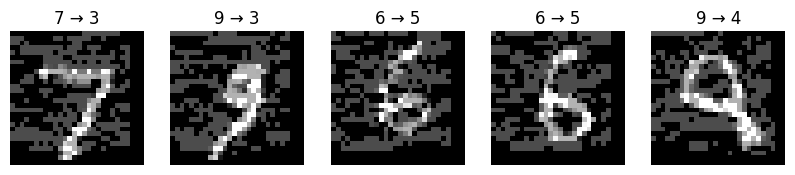

In [ ]:
def show_adversarial_examples(examples):
    plt.figure(figsize=(10,4))
    for i, (orig, adv, img) in enumerate(examples):
        plt.subplot(1,5,i+1)
        plt.title(f"{orig} → {adv}")
        plt.imshow(img.squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

show_adversarial_examples(examples)

#What Is Adversarial Training?

Instead of training only on clean images, we train on:
Clean + adversarial examples
This forces model to learn robustness.

It usually:
Slightly reduces clean accuracy
Improves adversarial accuracy
That tradeoff = your research conclusion.

Modify Training Loop

Add this new training function below your existing one.


In [ ]:
def train_adversarial(model, loader, epsilon):
    model.train()
    total_loss = 0

    for data, target in loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        model.zero_grad()
        loss.backward()

        # Generate adversarial data
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Forward pass again with adversarial data
        output_adv = model(perturbed_data)
        loss_adv = criterion(output_adv, target)

        optimizer.zero_grad()
        loss_adv.backward()
        optimizer.step()

        total_loss += loss_adv.item()

    return total_loss / len(loader)

#Create New Model for Robust Training

In [ ]:
robust_model = SimpleCNN().to(device)
optimizer = optim.Adam(robust_model.parameters(), lr=0.001)

#Train for 5 epochs:

In [ ]:
epsilon_train = 0.2

for epoch in range(5):
    loss = train_adversarial(robust_model, train_loader, epsilon_train)
    acc = test(robust_model, test_loader)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Clean Accuracy = {acc*100:.2f}%")

Epoch 1: Loss = 0.6652, Clean Accuracy = 96.82%
Epoch 2: Loss = 0.2770, Clean Accuracy = 96.18%
Epoch 3: Loss = 0.2364, Clean Accuracy = 97.77%
Epoch 4: Loss = 0.2597, Clean Accuracy = 98.36%
Epoch 5: Loss = 0.2324, Clean Accuracy = 98.37%


#Test Robust Model Under Attack

In [ ]:
acc_clean = test(robust_model, test_loader)
acc_adv, _ = test_fgsm(robust_model, device, test_loader, 0.2)

print("Robust Model Clean Accuracy:", acc_clean*100)
print("Robust Model Adversarial Accuracy:", acc_adv*100)

Robust Model Clean Accuracy: 98.37
Robust Model Adversarial Accuracy: 88.89


#Save Comparison Results

In [ ]:
baseline_clean_acc = 0.9872  # From the last epoch of baseline model training in cell dF60THNaVN1H
baseline_adv_acc = 0.4079 # From test_fgsm on baseline model with epsilon=0.2, in cell neKOc50GYI4c

print("=== FINAL COMPARISON ===")
print(f"Baseline Clean Accuracy: {baseline_clean_acc*100:.2f}%")
print(f"Baseline Adv Accuracy: {baseline_adv_acc*100:.2f}%")
print(f"Robust Clean Accuracy: {acc_clean*100:.2f}%")
print(f"Robust Adv Accuracy: {acc_adv*100:.2f}%")

=== FINAL COMPARISON ===
Baseline Clean Accuracy: 98.72%
Baseline Adv Accuracy: 40.79%
Robust Clean Accuracy: 98.37%
Robust Adv Accuracy: 88.89%


# Add simple plot:

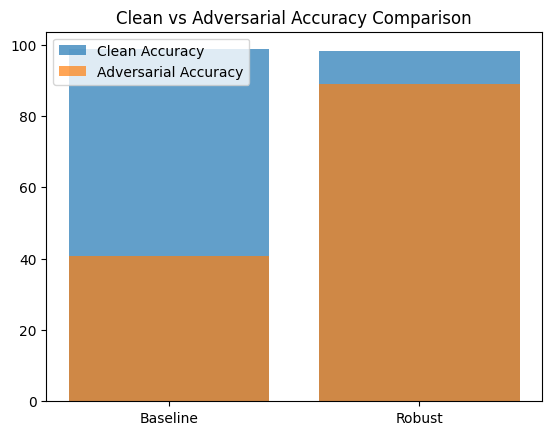

In [ ]:
import matplotlib.pyplot as plt

models = ['Baseline', 'Robust']
clean = [baseline_clean_acc*100, acc_clean*100]
adv = [baseline_adv_acc*100, acc_adv*100]

plt.bar(models, clean, alpha=0.7, label='Clean Accuracy')
plt.bar(models, adv, alpha=0.7, label='Adversarial Accuracy')
plt.legend()
plt.title("Clean vs Adversarial Accuracy Comparison")
plt.show()

## Results

| Model | Clean Accuracy | Adversarial Accuracy (ε = 0.2) |
|-------|---------------|------------------------------|
| Baseline CNN | 98.72% | 40.79% |
| Adversarially Trained CNN | 98.37% | 88.89% |

The baseline model performed well on clean data but poorly under attack. After adversarial training, robustness improved significantly with only a minor drop in clean accuracy.

## Conclusion

This experiment shows that CNNs are vulnerable to adversarial attacks, but adversarial training substantially improves robustness with minimal cost to standard performance. Future work could explore stronger attacks such as PGD and more advanced defense strategies.